In [2]:
#KerasCV설치하기
#0.9.0 아니고 개발버전 으로 다운로드 할 거임
!pip install git+https://github.com/keras-team/keras-cv.git


  Cloning https://github.com/keras-team/keras-cv.git to /tmp/pip-req-build-dzz9tmgx
  Running command git clone --filter=blob:none --quiet https://github.com/keras-team/keras-cv.git /tmp/pip-req-build-dzz9tmgx
  Resolved https://github.com/keras-team/keras-cv.git to commit 94b0a551d03ee9de3d81663e2c1a680cb113f7f1
  Installing build dependencies ... one
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached regex-2024.11.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (40 kB)
  Using cached tensorflow_datasets-4.9.8-py3-none-any.whl.metadata (11 kB)
  Using cached rich-14.0.0-py3-none-any.whl.metadata (18 kB)
  Using cached namex-0.0.9-py3-none-any.whl.metadata (322 bytes)
  Using cached dm_tree-0.1.9-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.2 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
  Us

In [ ]:
#label 형식이 있음 
labes={
    "boxes" : tf.Tensor,   #(batch_size, num_boxes, 4)
    "classes" : tf.Tensor  #(batch_szie, num_boxes)
}

In [7]:
#PASCAL VOC 형식을 tf.data.Dataset으로 변환하면 됨
ROOT_FOLDER ='/home/eva/jupyter_home/Keras_Object_Detection'
# !mkdir $ROOT_FOLDER
# cd $ROOT_FOLDER #/home/eva/jupyter_home/Keras_Object_Detection

In [12]:
!cp 

/home/eva/jupyter_home/Keras_Object_Detection


In [13]:
#PASCAL VOC2007버전이 있어야 함  (Keras_Object_Detection) 여기 폴더 안에 
!cp /home/eva/jupyter_home/YOLO_Object_Detection/VOC/VOCtrainval_06-Nov-2007.tar .

In [14]:
#압축을 풀어야 함 
!tar xvf VOCtrainval_06-Nov-2007.tar

VOCdevkit/
VOCdevkit/VOC2007/
VOCdevkit/VOC2007/Annotations/
VOCdevkit/VOC2007/Annotations/000005.xml
VOCdevkit/VOC2007/Annotations/000007.xml
VOCdevkit/VOC2007/Annotations/000009.xml
VOCdevkit/VOC2007/Annotations/000012.xml
VOCdevkit/VOC2007/Annotations/000016.xml
VOCdevkit/VOC2007/Annotations/000017.xml
VOCdevkit/VOC2007/Annotations/000019.xml
VOCdevkit/VOC2007/Annotations/000020.xml
VOCdevkit/VOC2007/Annotations/000021.xml
VOCdevkit/VOC2007/Annotations/000023.xml
VOCdevkit/VOC2007/Annotations/000024.xml
VOCdevkit/VOC2007/Annotations/000026.xml
VOCdevkit/VOC2007/Annotations/000030.xml
VOCdevkit/VOC2007/Annotations/000032.xml
VOCdevkit/VOC2007/Annotations/000033.xml
VOCdevkit/VOC2007/Annotations/000034.xml
VOCdevkit/VOC2007/Annotations/000035.xml
VOCdevkit/VOC2007/Annotations/000036.xml
VOCdevkit/VOC2007/Annotations/000039.xml
VOCdevkit/VOC2007/Annotations/000041.xml
VOCdevkit/VOC2007/Annotations/000042.xml
VOCdevkit/VOC2007/Annotations/000044.xml
VOCdevkit/VOC2007/Annotations/000046.

In [15]:
#TFRecord로 변환하기 
import os
import tensorflow as tf
import xml.etree.ElementTree as ET

# VOC 클래스 목록 (20 classes)
VOC_CLASSES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle",
    "bus", "car", "cat", "chair", "cow",
    "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]
class_name_to_id = {name: i for i, name in enumerate(VOC_CLASSES)}

def parse_voc_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    filename = root.find("filename").text
    size = root.find("size")
    width = int(size.find("width").text)
    height = int(size.find("height").text)

    bboxes = []
    labels = []

    for obj in root.findall("object"):
        name = obj.find("name").text
        label = class_name_to_id[name]

        bbox = obj.find("bndbox")
        xmin = int(float(bbox.find("xmin").text))
        ymin = int(float(bbox.find("ymin").text))
        xmax = int(float(bbox.find("xmax").text))
        ymax = int(float(bbox.find("ymax").text))

        bboxes.append([xmin, ymin, xmax, ymax])
        labels.append(label)

    return filename, width, height, bboxes, labels

def create_tf_example(image_path, xml_path):
    filename, width, height, bboxes, labels = parse_voc_xml(xml_path)

    with tf.io.gfile.GFile(image_path, 'rb') as fid:
        encoded_image = fid.read()

    xmins = [box[0] / width for box in bboxes]
    ymins = [box[1] / height for box in bboxes]
    xmaxs = [box[2] / width for box in bboxes]
    ymaxs = [box[3] / height for box in bboxes]

    classes_text = [VOC_CLASSES[label].encode('utf8') for label in labels]
    classes = labels

    feature = {
        'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[encoded_image])),
        'image/filename': tf.train.Feature(bytes_list=tf.train.BytesList(value=[filename.encode('utf8')])),
        'image/height': tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width': tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/object/bbox/xmin': tf.train.Feature(float_list=tf.train.FloatList(value=xmins)),
        'image/object/bbox/ymin': tf.train.Feature(float_list=tf.train.FloatList(value=ymins)),
        'image/object/bbox/xmax': tf.train.Feature(float_list=tf.train.FloatList(value=xmaxs)),
        'image/object/bbox/ymax': tf.train.Feature(float_list=tf.train.FloatList(value=ymaxs)),
        'image/object/class/text': tf.train.Feature(bytes_list=tf.train.BytesList(value=classes_text)),
        'image/object/class/label': tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
    }

    example = tf.train.Example(features=tf.train.Features(feature=feature))
    return example

def generate_tfrecord(voc_dir, split_txt, output_path):
    annotation_dir = os.path.join(voc_dir, 'Annotations')
    image_dir = os.path.join(voc_dir, 'JPEGImages')

    with tf.io.TFRecordWriter(output_path) as writer:
        with open(split_txt, 'r') as f:
            lines = f.read().strip().splitlines()

        for img_id in lines:
            xml_path = os.path.join(annotation_dir, f"{img_id}.xml")
            img_path = os.path.join(image_dir, f"{img_id}.jpg")

            if os.path.exists(xml_path) and os.path.exists(img_path):
                example = create_tf_example(img_path, xml_path)
                writer.write(example.SerializeToString())

VOC_ROOT_DIR = '/home/eva/jupyter_home/Keras_Object_Detection'

# 실행
generate_tfrecord(
    voc_dir=VOC_ROOT_DIR + "/VOCdevkit/VOC2007",
    split_txt=VOC_ROOT_DIR + "/VOCdevkit/VOC2007/ImageSets/Main/train.txt",
    output_path=VOC_ROOT_DIR + "/voc2007_train.tfrecord" #만들어 지는 파일  
)

generate_tfrecord(
    voc_dir=VOC_ROOT_DIR + "/VOCdevkit/VOC2007",
    split_txt=VOC_ROOT_DIR + "/VOCdevkit/VOC2007/ImageSets/Main/val.txt",
    output_path=VOC_ROOT_DIR + "/voc2007_val.tfrecord"
)

In [16]:
#실제 모델학습에 필요한 tf.data.Dataset생성 하기 

IMAGE_SIZE = 512

def parse_tfrecord(example):
    features = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    }

    parsed = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(parsed['image/encoded'], channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)

    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])

    xmins = tf.sparse.to_dense(parsed['image/object/bbox/xmin'])
    ymins = tf.sparse.to_dense(parsed['image/object/bbox/ymin'])
    xmaxs = tf.sparse.to_dense(parsed['image/object/bbox/xmax'])
    ymaxs = tf.sparse.to_dense(parsed['image/object/bbox/ymax'])
    labels = tf.sparse.to_dense(parsed['image/object/class/label'])

    boxes = tf.stack([xmins, ymins, xmaxs, ymaxs], axis=-1)

    return {
        "images": image,
        "bounding_boxes": {
            "boxes": boxes,
            "classes": tf.cast(labels, tf.int32),
        }
    }

def load_dataset(tfrecord_path, batch_size=8):
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    dataset = dataset.map(parse_tfrecord, 
                          num_parallel_calls=tf.data.AUTOTUNE)
    
    # padded_batch 필수
    dataset = dataset.shuffle(1000).padded_batch(
        batch_size,
        padded_shapes={
            "images": [IMAGE_SIZE, IMAGE_SIZE, 3],
            "bounding_boxes": {
                "boxes": [None, 4],
                "classes": [None]
            }
        },
        drop_remainder=True
    ).prefetch(tf.data.AUTOTUNE)

    return dataset

#데이터 셋 만들기 
train_ds = load_dataset("./voc2007_train.tfrecord", 
                        batch_size=8)

val_ds = load_dataset("./voc2007_val.tfrecord", 
                        batch_size=8)     


In [20]:
#재학습에 필요한 데이터 셋 준비 끝! 
#keras 형식으로 모델 생성
from keras_cv.models import RetinaNet
#이미 만들어 놓은 모델을 가지고 와서 만들어야 함! : from_preset() 
#어떤 preset()이 있는지 확인 필요함!
#모델 만들기 
model=RetinaNet.from_preset(
    'retinanet_resnet50_pascalvoc',
    bounding_box_format='xyxy', #좌표 4개 (4개의 점을 이용해서 만듬) / xywh-> 이것도 있음 (중앙점을 이용해서 가로 세로 길이 구함)
    num_classes=20
)


100%|██████████████████████████████████████████████████████████████████████| 136M/136M [00:15<00:00, 9.23MB/s]
/home/eva/anaconda3/envs/keras_env/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/home/eva/anaconda3/envs/keras_env/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


In [18]:
#preset의 모델들~ : 우리가 사용하는 모델 (retinanet_resnet50_pascalvoc)
from keras_cv.models import RetinaNet
print(RetinaNet.presets.keys())

dict_keys(['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'resnet18_v2', 'resnet34_v2', 'resnet50_v2', 'resnet101_v2', 'resnet152_v2', 'mobilenet_v3_small', 'mobilenet_v3_large', 'csp_darknet_tiny', 'csp_darknet_s', 'csp_darknet_m', 'csp_darknet_l', 'csp_darknet_xl', 'efficientnetv1_b0', 'efficientnetv1_b1', 'efficientnetv1_b2', 'efficientnetv1_b3', 'efficientnetv1_b4', 'efficientnetv1_b5', 'efficientnetv1_b6', 'efficientnetv1_b7', 'efficientnetv2_s', 'efficientnetv2_m', 'efficientnetv2_l', 'efficientnetv2_b0', 'efficientnetv2_b1', 'efficientnetv2_b2', 'efficientnetv2_b3', 'densenet121', 'densenet169', 'densenet201', 'efficientnetlite_b0', 'efficientnetlite_b1', 'efficientnetlite_b2', 'efficientnetlite_b3', 'efficientnetlite_b4', 'yolo_v8_xs_backbone', 'yolo_v8_s_backbone', 'yolo_v8_m_backbone', 'yolo_v8_l_backbone', 'yolo_v8_xl_backbone', 'vitdet_base', 'vitdet_large', 'vitdet_huge', 'videoswin_tiny', 'videoswin_small', 'videoswin_base', 'resnet50_imagenet', 'resnet50_v

In [22]:
#모델 컴파일
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=1e-4),
             classification_loss='focal',
             box_loss='smoothl1')

In [23]:
#모델 재 학습

model.fit(train_ds,
         epochs=10,
         verbose=1)

Epoch 1/10
312/312 [==============================] - 130s 314ms/step - loss: 0.0000e+00 - box_loss: 0.0000e+00 - classification_loss: 0.0000e+00 - percent_boxes_matched_with_anchor: 0.8115
Epoch 2/10
312/312 [==============================] - 99s 316ms/step - loss: 0.0000e+00 - box_loss: 0.0000e+00 - classification_loss: 0.0000e+00 - percent_boxes_matched_with_anchor: 0.8112
Epoch 3/10
312/312 [==============================] - 99s 316ms/step - loss: 0.0000e+00 - box_loss: 0.0000e+00 - classification_loss: 0.0000e+00 - percent_boxes_matched_with_anchor: 0.8142
Epoch 4/10
312/312 [==============================] - 99s 315ms/step - loss: 0.0000e+00 - box_loss: 0.0000e+00 - classification_loss: 0.0000e+00 - percent_boxes_matched_with_anchor: 0.8074
Epoch 5/10
312/312 [==============================] - 98s 314ms/step - loss: 0.0000e+00 - box_loss: 0.0000e+00 - classification_loss: 0.0000e+00 - percent_boxes_matched_with_anchor: 0.8063
Epoch 6/10
312/312 [==============================] - 

1/1 [==============================] - 9s 9s/step


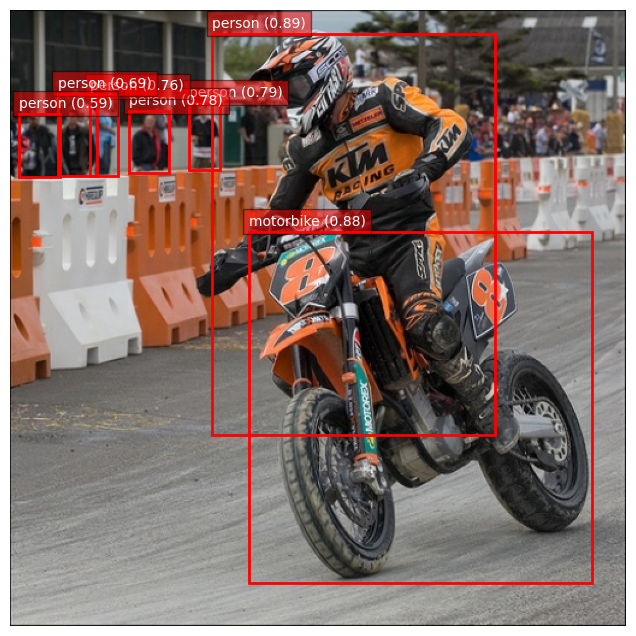

In [24]:
#예측 시각화 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

VOC_CLASSES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle",
    "bus", "car", "cat", "chair", "cow",
    "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]

def visualize_prediction(image, boxes, classes, scores, threshold=0.3):
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)

    for box, cls, score in zip(boxes, classes, scores):
        if score < threshold:
            continue
        
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        rect = patches.Rectangle(
            (x1, y1), w, h,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        class_name = VOC_CLASSES[int(cls)]
        ax.text(
            x1, y1 - 5,
            f"{class_name} ({score:.2f})",
            fontsize=10,
            color="white",
            bbox=dict(facecolor="red", alpha=0.5)
        )

    plt.axis("off")
    plt.show()

# 예측 결과 (batched)
sample = next(iter(val_ds))
images, y_true = sample["images"], sample["bounding_boxes"]

# 예측 (batched)
y_pred = model.predict(images)

# 첫 번째 이미지만 시각화
image = images[0].numpy()
# 이미지 크기에 맞게 scale (RetinaNet은 512x512로 resize됨)
image = np.clip(image * 255, 0, 255).astype("uint8")

boxes = y_pred["boxes"][0]
classes = y_pred["classes"][0]
scores = y_pred["confidence"][0]

visualize_prediction(image, boxes, classes, scores, threshold=0.3)

In [ ]:
/home/eva/jupyter_home/TF2_Object_Detection/fire/VOCdevkit/VOC2007/JPEGImages

In [26]:
##fire

In [29]:
cd keras_fire

/home/eva/jupyter_home/keras_fire


In [35]:
import os

# 작업할 디렉토리 경로
directory = '/home/eva/jupyter_home/keras_fire/VOCdevkit/VOC2007/ImageSets/Main'

# 디렉토리 내 파일 목록 가져오기
files = os.listdir(directory)

# 각 파일에 대해 공백을 _로 변경하고 번호는 그대로 두기
for filename in files:
    new_filename = filename.replace(' ', '_')  # 공백을 _로 바꿈
    os.rename(os.path.join(directory, filename), os.path.join(directory, new_filename))
    print(f"Renamed {filename} to {new_filename}")


Renamed train.txt to train.txt


In [61]:
import os

def generate_annotation_paths(voc_dir, split_txt):
    annotation_dir = os.path.join(voc_dir, 'Annotations')  # Annotations 폴더 경로
    annotation_paths = []  # 결과를 저장할 리스트
    
    with open(split_txt, 'r') as f:
        lines = f.read().strip().splitlines()
    
    for img_id in lines:
        # 다양한 패턴으로 XML 파일을 생성 (img(1), pic(1), small(1) 등)
        xml_filename_patterns = [f"img({img_id}).xml", f"pic({img_id}).xml", f"small({img_id}).xml"]
        
        for xml_filename in xml_filename_patterns:
            xml_path = os.path.join(annotation_dir, xml_filename)
            
            # XML 파일이 존재하면 경로를 리스트에 추가
            if os.path.exists(xml_path):
                annotation_paths.append(xml_path)
                break  # 하나만 찾으면 다음 이미지로 넘어감
        
    return annotation_paths

# 실행 예시
VOC_ROOT_DIR = '/home/eva/jupyter_home/keras_fire'

annotation_paths = generate_annotation_paths(
    voc_dir=VOC_ROOT_DIR + "/VOCdevkit/VOC2007",
    split_txt=VOC_ROOT_DIR + "/VOCdevkit/VOC2007/ImageSets/Main/train.txt"
)

# 결과 확인
for path in annotation_paths:
    print(path)


In [65]:
#TFRecord로 변환하기 
import os
import tensorflow as tf
import xml.etree.ElementTree as ET

# VOC 클래스 목록 (20 classes)
VOC_CLASSES = [
    "fire"
]
class_name_to_id = {name: i for i, name in enumerate(VOC_CLASSES)}

def parse_voc_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    filename = root.find("filename").text
    size = root.find("size")
    width = int(size.find("width").text)
    height = int(size.find("height").text)

    bboxes = []
    labels = []

    for obj in root.findall("object"):
        name = obj.find("name").text
        label = class_name_to_id[name]

        bbox = obj.find("bndbox")
        xmin = int(float(bbox.find("xmin").text))
        ymin = int(float(bbox.find("ymin").text))
        xmax = int(float(bbox.find("xmax").text))
        ymax = int(float(bbox.find("ymax").text))

        bboxes.append([xmin, ymin, xmax, ymax])
        labels.append(label)

    return filename, width, height, bboxes, labels

def create_tf_example(image_path, xml_path):
    filename, width, height, bboxes, labels = parse_voc_xml(xml_path)

    with tf.io.gfile.GFile(image_path, 'rb') as fid:
        encoded_image = fid.read()

    xmins = [box[0] / width for box in bboxes]
    ymins = [box[1] / height for box in bboxes]
    xmaxs = [box[2] / width for box in bboxes]
    ymaxs = [box[3] / height for box in bboxes]

    classes_text = [VOC_CLASSES[label].encode('utf8') for label in labels]
    classes = labels

    feature = {
        'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[encoded_image])),
        'image/filename': tf.train.Feature(bytes_list=tf.train.BytesList(value=[filename.encode('utf8')])),
        'image/height': tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width': tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/object/bbox/xmin': tf.train.Feature(float_list=tf.train.FloatList(value=xmins)),
        'image/object/bbox/ymin': tf.train.Feature(float_list=tf.train.FloatList(value=ymins)),
        'image/object/bbox/xmax': tf.train.Feature(float_list=tf.train.FloatList(value=xmaxs)),
        'image/object/bbox/ymax': tf.train.Feature(float_list=tf.train.FloatList(value=ymaxs)),
        'image/object/class/text': tf.train.Feature(bytes_list=tf.train.BytesList(value=classes_text)),
        'image/object/class/label': tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
    }

    example = tf.train.Example(features=tf.train.Features(feature=feature))
    return example

def generate_tfrecord(voc_dir, split_txt, output_path):
    annotation_dir = os.path.join(voc_dir, 'Annotations')
    image_dir = os.path.join(voc_dir, 'JPEGImages')

    with tf.io.TFRecordWriter(output_path) as writer:
        with open(split_txt, 'r') as f:
            lines = f.read().strip().splitlines()

        for img_id in lines:
            xml_path = os.path.join(annotation_dir, f"{img_id}.xml")
            img_path = os.path.join(image_dir, f"{img_id}.jpg")

            if os.path.exists(xml_path) and os.path.exists(img_path):
                example = create_tf_example(img_path, xml_path)
                writer.write(example.SerializeToString())

VOC_ROOT_DIR = '/home/eva/jupyter_home/keras_fire'

# 실행
#keras_fire/VOCdevkit/VOC2007
generate_tfrecord(
    voc_dir=VOC_ROOT_DIR + "/VOCdevkit/VOC2007",
    split_txt=VOC_ROOT_DIR + "/VOCdevkit/VOC2007/ImageSets/Main/train.txt",
    output_path=VOC_ROOT_DIR + "/voc2007_train.tfrecord" #만들어 지는 파일  
)

generate_tfrecord(
    voc_dir=VOC_ROOT_DIR + "/VOCdevkit/VOC2007",
    split_txt=VOC_ROOT_DIR + "/VOCdevkit/VOC2007/ImageSets/Main/validation.txt",
    output_path=VOC_ROOT_DIR + "/voc2007_val.tfrecord"
)

In [66]:
#실제 모델학습에 필요한 tf.data.Dataset생성 하기 

IMAGE_SIZE = 512

def parse_tfrecord(example):
    features = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    }

    parsed = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(parsed['image/encoded'], channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)

    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])

    xmins = tf.sparse.to_dense(parsed['image/object/bbox/xmin'])
    ymins = tf.sparse.to_dense(parsed['image/object/bbox/ymin'])
    xmaxs = tf.sparse.to_dense(parsed['image/object/bbox/xmax'])
    ymaxs = tf.sparse.to_dense(parsed['image/object/bbox/ymax'])
    labels = tf.sparse.to_dense(parsed['image/object/class/label'])

    boxes = tf.stack([xmins, ymins, xmaxs, ymaxs], axis=-1)

    return {
        "images": image,
        "bounding_boxes": {
            "boxes": boxes,
            "classes": tf.cast(labels, tf.int32),
        }
    }

def load_dataset(tfrecord_path, batch_size=8):
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    dataset = dataset.map(parse_tfrecord, 
                          num_parallel_calls=tf.data.AUTOTUNE)
    
    # padded_batch 필수
    dataset = dataset.shuffle(1000).padded_batch(
        batch_size,
        padded_shapes={
            "images": [IMAGE_SIZE, IMAGE_SIZE, 3],
            "bounding_boxes": {
                "boxes": [None, 4],
                "classes": [None]
            }
        },
        drop_remainder=True
    ).prefetch(tf.data.AUTOTUNE)

    return dataset

#데이터 셋 만들기 
train_ds = load_dataset("./voc2007_train.tfrecord", 
                        batch_size=8)

val_ds = load_dataset("./voc2007_val.tfrecord", 
                        batch_size=8)     


In [95]:
from keras_cv.models import RetinaNet
#이미 만들어 놓은 모델을 가지고 와서 만들어야 함! : from_preset() 
#어떤 preset()이 있는지 확인 필요함!
#모델 만들기 
model=RetinaNet.from_preset(
    'resnet50',
    bounding_box_format='xyxy', #좌표 4개 (4개의 점을 이용해서 만듬) / xywh-> 이것도 있음 (중앙점을 이용해서 가로 세로 길이 구함)
    num_classes=1
)

In [101]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=1e-2),
             classification_loss='focal',
             box_loss='smoothl1')


In [102]:
model.fit(train_ds,
         epochs=20,
         verbose=1)

Epoch 1/20
51/51 [==============================] - 35s 303ms/step - loss: 0.0000e+00 - box_loss: 0.0000e+00 - classification_loss: 0.0000e+00 - percent_boxes_matched_with_anchor: 0.5629
Epoch 2/20
51/51 [==============================] - 15s 297ms/step - loss: 0.0000e+00 - box_loss: 0.0000e+00 - classification_loss: 0.0000e+00 - percent_boxes_matched_with_anchor: 0.5340
Epoch 3/20
51/51 [==============================] - 15s 297ms/step - loss: 0.0000e+00 - box_loss: 0.0000e+00 - classification_loss: 0.0000e+00 - percent_boxes_matched_with_anchor: 0.5423
Epoch 4/20
51/51 [==============================] - 15s 300ms/step - loss: 0.0000e+00 - box_loss: 0.0000e+00 - classification_loss: 0.0000e+00 - percent_boxes_matched_with_anchor: 0.5551
Epoch 5/20
51/51 [==============================] - 15s 297ms/step - loss: 0.0000e+00 - box_loss: 0.0000e+00 - classification_loss: 0.0000e+00 - percent_boxes_matched_with_anchor: 0.5767
Epoch 6/20
51/51 [==============================] - 15s 298ms/ste

1/1 [==============================] - 5s 5s/step


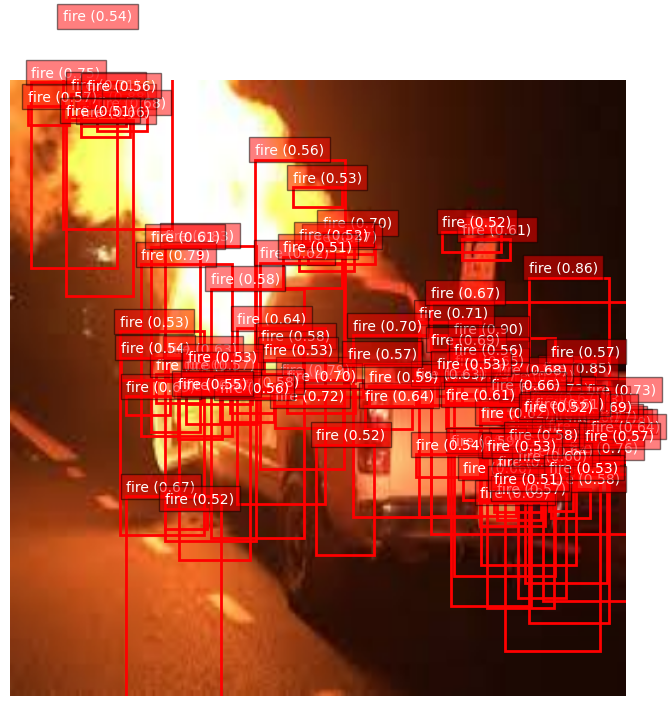

In [104]:
#예측 시각화 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

VOC_CLASSES = [
    "fire"
]

def visualize_prediction(image, boxes, classes, scores, threshold=0.3):
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)

    for box, cls, score in zip(boxes, classes, scores):
        if score < threshold:
            continue
        
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        rect = patches.Rectangle(
            (x1, y1), w, h,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        class_name = VOC_CLASSES[int(cls)]
        ax.text(
            x1, y1 - 5,
            f"{class_name} ({score:.2f})",
            fontsize=10,
            color="white",
            bbox=dict(facecolor="red", alpha=0.5)
        )

    plt.axis("off")
    plt.show()

# 예측 결과 (batched)
sample = next(iter(val_ds))
images, y_true = sample["images"], sample["bounding_boxes"]

# 예측 (batched)
y_pred = model.predict(images)

# 첫 번째 이미지만 시각화
image = images[0].numpy()
# 이미지 크기에 맞게 scale (RetinaNet은 512x512로 resize됨)
image = np.clip(image * 255, 0, 255).astype("uint8")

boxes = y_pred["boxes"][0]
classes = y_pred["classes"][0]
scores = y_pred["confidence"][0]

visualize_prediction(image, boxes, classes, scores, threshold=0.3)